# Testing Battery Decision Reasoning with Heuristic Solver

This notebook demonstrates the reasoning pipeline integrated with the heuristic solver to explain battery charging/discharging decisions.

**What this shows:**
- Running heuristic optimization (time-based and quantile-based strategies)
- Using LLM to generate natural language explanations for battery decisions
- Visualizing decisions with their context

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Import project modules
# Note: Importing agentic_energy.agentics_reasoning automatically applies the Agentics framework patch
from agentic_energy.heuristics.heuristic_trader import HeuristicTrader, records_to_arrays
from agentic_energy.data_loader import EnergyDataLoader
from agentic_energy.schemas import BatteryParams, DayInputs, SolveRequest, SolveResponse, ReasoningRequest, ReasoningResponse
from agentic_energy.reasoning.reasoning_module import BatteryReasoningAG

Available LLM providers: ['gemini', 'openai', 'ollama']


## Load Test Data
Load Italy market data for testing

In [2]:
# Load Italy market data
italy_obj = EnergyDataLoader(region="ITALY")
italy_data = italy_obj.load_region_data()

# Get first day of data (24 hours)
day_records = italy_data[0:24]
prices, demand = records_to_arrays(day_records)


print(f"Loaded {len(day_records)} hours of data")
print(f"Price range: ${min(prices):.2f} - ${max(prices):.2f}/MWh")
print(f"Demand range: {min(demand):.2f} - {max(demand):.2f} MW")

2025-11-23 15:46:11.248 | DEBUG    | agentics.core.agentics:from_csv:307 - Importing Agentics of type EnergyDataRecord from CSV /Users/millendroy/Projects/Agentic_Energy/Agentics_for_EnergyArbitrage_Battery/agentic_energy/agentic_energy/data/Italy_data_actual.csv


Loaded 24 hours of data
Price range: $36.00 - $54.30/MWh
Demand range: 19.49 - 30.97 MW


## Setup Battery and Heuristic Strategies

In [3]:
# Define battery parameters
battery = BatteryParams(
    capacity_MWh=49.44,
    cmax_MW=12.36,
    dmax_MW=12.36,
    soc_init=0.5,
    soc_min=0.0,
    soc_max=1.0,
    eta_c=0.95,
    eta_d=0.95,
    soc_target=0.5,
)

# Create day inputs
day = DayInputs(
    prices_buy=prices,
    prices_sell=prices,
    demand_MW=demand,
    allow_export=True,
    dt_hours=1.0,
)

# Create time-based heuristic trader
trader_time = HeuristicTrader(
    mode="time",
    charge_windows=[(2, 6), (10, 16), (20, 22)],
    discharge_windows=[(0, 2), (6, 10), (16, 20), (22, 24)],
)

# Create solve request
req_time = SolveRequest(
    battery=battery,
    day=day,
    solver=None,
    solver_opts={"mode": "time"},
)

print("✓ Battery and strategy configured")

✓ Battery and strategy configured


## Run Heuristic Optimization

In [4]:
# Run the time-based heuristic
result_time = trader_time.solve(req_time)

print(f"Time-based strategy results:")
print(f"  Status: {result_time.status}")
print(f"  Objective cost: ${result_time.objective_cost:.2f}")
print(f"  Decisions: {len(result_time.decision)} timesteps")

# Summary of decisions
decisions_array = np.array(result_time.decision)
n_charge = np.sum(decisions_array == 1.0)
n_discharge = np.sum(decisions_array == -1.0)
n_idle = np.sum(decisions_array == 0.0)
print(f"  Charge: {n_charge} hours, Discharge: {n_discharge} hours, Idle: {n_idle} hours")

Time-based strategy results:
  Status: ok-time
  Objective cost: $25836.98
  Decisions: 24 timesteps
  Charge: 12 hours, Discharge: 12 hours, Idle: 0 hours


## Initialize Reasoning System

Create the LLM-based reasoning system that will explain the decisions.

In [5]:
# Initialize reasoning system with Gemini
# You can also try "openai" or other providers
reasoning = BatteryReasoningAG(llm_provider="gemini")

print("✓ Reasoning system initialized")

✓ Reasoning system initialized


## Generate Explanations for Key Decisions

Let's explain decisions at a few interesting timesteps (beginning, middle, end of day)

In [8]:
# interesting_hours = [0, 6, 12, 18]
r_req = ReasoningRequest(
                solve_request=req_time,
                solve_response=result_time,
                timestamp_index=5,
                context_window=6,  # e.g., 6 timesteps before/after
            )

explanations=await reasoning.explain_decision(r_req)
print(explanations)
# decision_labels = {1.0: "CHARGE", 0.0: "IDLE", -1.0: "DISCHARGE"}

# for hour, explanation in zip(interesting_hours, explanations):
#     decision = result_time.decision[hour]
#     soc = result_time.soc[hour]
#     price = prices[hour]
    
#     print(f"\n{'='*80}")
#     print(f"HOUR {hour} - Decision: {decision_labels.get(decision, decision)}")
#     print(f"SoC: {soc:.1%} | Price: ${price:.2f}/MWh | Demand: {demand[hour]:.2f} MW")
#     print(f"{'-'*80}")
#     print(f"\nEXPLANATION (Confidence: {explanation.confidence:.0%}):\n")
#     print(explanation.explanation)
    
#     if explanation.key_factors:
#         print(f"\nKEY FACTORS:")
#         for factor in explanation.key_factors:
#             print(f"  • {factor}")
    
#     if explanation.supporting_data:
#         print(f"\nSUPPORTING DATA:")
#         for key, value in explanation.supporting_data.items():
#             print(f"  • {key}: {value:.4f}")

# print(f"\n{'='*80}")

╭──────────────────────────────────────────── Crew Execution Started ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name: crew                                                                                                     │
│  ID: 304618f2-5ac8-4058-bdfc-141d48f79088                                                                       │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Task Executor                                                                                           │
│                                                                                                                 │
│  Task:                                                                                                          │
│  Your task is to transduce a source Pydantic Object into the specified Output type. Generate only slots that    │
│  are logically deduced from the input information, otherwise live then null.                                    │
│                                                                                                                 │
│  Read carefully the following instructions for executing your task:                                             │
│                                                                                                                 │
│              You are an expert system explaining battery charging/discharging/idle decisions in an energy       │
│  arbitrage context.                                                                                             │
│              Analyze the provided data including:                                                               │
│              1. Battery state (SoC, capacity, efficiency)                                                       │
│              2. Market conditions (prices, demand)                                                              │
│              3. Algorithm decisions (charge/discharge/idle)                                                     │
│                                                                                                                 │
│              Explain why the decision was optimal given the constraints and objectives.                         │
│              Consider:                                                                                          │
│              - Price patterns and arbitrage opportunities                                                       │
│              - Battery constraints (capacity, power limits)                                                     │
│              - Efficiency losses                                                                                │
│              - Future price expectations if available                                                           │
│               SOURCE:                                                                                           │
│  {"solve_request": {"battery": {"capacity_MWh": 49.44, "soc_init": 0.5, "soc_min": 0.0, "soc_max": 1.0,         │
│  "cmax_MW": 12.36, "dmax_MW": 12.36, "eta_c": 0.95, "eta_d": 0.95, "soc_target": 0.5}, "day": {"prices_buy":    │
│  [45.82, 44.16, 42.24, 39.29, 36.0, 41.99, 42.25, 44.97, 45.0, 44.94, 45.02, 45.71, 46.7, 43.98, 44.96, 47.53,  │
│  49.91, 54.3, 51.91, 51.38, 49.2, 45.73, 44.84, 38.11], "demand_MW": [22.98, 21.81, 20.76, 19.97, 19.49,        │
│  19.84, 21.1, 22.1, 22.4, 23.59, 24.37, 24.96, 25.06, 23.9, 23.49, 23.76, 25.24, 29.1, 30.35, 30.97, 30.34,     │
│  28.82, 26.54, 24.05], "prices_sell": [45.82, 44.16, 42.24, 39.29, 36.0, 41.99, 42.25, 44.97, 45.0, 44.94,      │
│  45.02, 45.71, 46.7, 43.98, 44.96, 47.53, 49.91, 54.3, 51.91, 51.38, 49.2, 45.73, 44.84, 38.11],                │
│  "allow_export": true, "dt_hours": 1.0, "prices_buy_forecast": null, "demand_MW_forecast": null,                │
│  "prices_sell_forecast": null}, "solver": null, "solver_opts": {"mode": "time"}}, "solve_response": {"status":  │
│  "ok-time", "message": null, "objective_cost": 25836.98497063158, "charge_MW": [0.0, 0.0, 12.36, 12.36, 12.36,  │
│  12.36, 0.0, 0.0, 0.0, 0.0, 12.36, 12.36, 12.36, 12.36,

Output()

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Task Executor                                                                                           │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  ```json                                                                                                        │
│  {                                                                                                              │
│    "explanation": "The battery control strategy appears to be exploiting price arbitrage opportunities. During  │
│  hours 0 and 1, the battery discharges at its maximum rate (12.36 MW and 11.124 MW respectively) when prices    │
│  are relatively high (45.82 and 44.16). This reduces the SoC to 0 by hour 1. From hour 2 to 5, the battery      │
│  charges at its maximum rate (12.36 MW) when prices are lower (42.24, 39.29, 36.0, 41.99), increasing the SoC   │
│  to 0.95 by hour 5. The battery then idles at hour 6 and 7, while the price is at 42.25 and 44.97               │
│  respectively. The battery discharges from hour 7 to 10, and charges again from hour 10 to 14, repeating the    │
│  price arbitrage strategy. The battery constraints, such as maximum charge/discharge rates and SoC limits, are  │
│  respected. Efficiency losses (eta_c = 0.95, eta_d = 0.95) are implicitly considered in the optimization. The   │
│  objective function aims to maximize profit by charging when prices are low and discharging when prices are     │
│  high. Note that the SoC target of 0.5 is not strictly enforced, as the algorithm prioritizes maximizing        │
│  profits within the given timeframe. The final few hours again show the same pattern. The algorithm uses the    │
│  prices in the current time window, without considering future price expectations, as the                       │
│  `prices_buy_forecast` and `prices_sell_forecast` are null.",                                                   │
│    "key_factors": [                                                                                             │
│      "Price arbitrage opportunities (difference between buy and sell prices)",                                  │
│      "Battery SoC level",                                                                                       │
│      "Battery capacity and charge/discharge rate limits",                                                       │
│      "Battery charging/discharging efficiency",                                                                 │
│      "Allow export is true"                                                                                     │
│    ],                                                                                                           │
│    "confidence": 0.95,                                                                                          │
│    "supporting_data": {                                                                                         │
│      "Initial SoC": 0.5,                                                                                        │
│      "Capacity (MWh)": 49.44,                                                                                   │
│      "Max Charge Rate (MW)": 12.36,                                                                             │
│      "Max Discharge Rate (MW)": 12.36,                                                                          │
│      "Charge Efficiency": 0.95,                                                                                 │
│      "Discharge Efficiency": 0.95,                     

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: 383452e0-4720-40a4-9b53-998d6a3f6e2d                                                                     │
│  Agent: Task Executor                                                                                           │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name: crew                                                                                                     │
│  ID: 304618f2-5ac8-4058-bdfc-141d48f79088                                                                       │
│  Tool Args:                                                                                                     │
│  Final Output: ```json                                                                                          │
│  {                                                                                                              │
│    "explanation": "The battery control strategy appears to be exploiting price arbitrage opportunities. During  │
│  hours 0 and 1, the battery discharges at its maximum rate (12.36 MW and 11.124 MW respectively) when prices    │
│  are relatively high (45.82 and 44.16). This reduces the SoC to 0 by hour 1. From hour 2 to 5, the battery      │
│  charges at its maximum rate (12.36 MW) when prices are lower (42.24, 39.29, 36.0, 41.99), increasing the SoC   │
│  to 0.95 by hour 5. The battery then idles at hour 6 and 7, while the price is at 42.25 and 44.97               │
│  respectively. The battery discharges from hour 7 to 10, and charges again from hour 10 to 14, repeating the    │
│  price arbitrage strategy. The battery constraints, such as maximum charge/discharge rates and SoC limits, are  │
│  respected. Efficiency losses (eta_c = 0.95, eta_d = 0.95) are implicitly considered in the optimization. The   │
│  objective function aims to maximize profit by charging when prices are low and discharging when prices are     │
│  high. Note that the SoC target of 0.5 is not strictly enforced, as the algorithm prioritizes maximizing        │
│  profits within the given timeframe. The final few hours again show the same pattern. The algorithm uses the    │
│  prices in the current time window, without considering future price expectations, as the                       │
│  `prices_buy_forecast` and `prices_sell_forecast` are null.",                                                   │
│    "key_factors": [                                                                                             │
│      "Price arbitrage opportunities (difference between buy and sell prices)",                                  │
│      "Battery SoC level",                                                                                       │
│      "Battery capacity and charge/discharge rate limits",                                                       │
│      "Battery charging/discharging efficiency",                                                                 │
│      "Allow export is true"                                                                                     │
│    ],                                                                                                           │
│    "confidence": 0.95,                                                                                          │
│    "supporting_data": {                                                                                         │
│      "Initial SoC": 0.5,                                                                                        │
│      "Capacity (MWh)": 49.44,                                                                                   │
│      "Max Charge Rate (MW)": 12.36,                                                                             │
│      "Max Discharge Rate (MW)": 12.36,                                                                          │
│      "Charge Efficiency": 0.95,                       

atype=<class 'agentic_energy.schemas.ReasoningResponse'> crew_prompt_params={'role': 'Task Executor', 'goal': 'You execute tasks', 'backstory': 'You are always faithful and provide only fact based answers.', 'expected_output': 'Described by Pydantic Type'} instructions='\n            You are an expert system explaining battery charging/discharging/idle decisions in an energy arbitrage context.\n            Analyze the provided data including:\n            1. Battery state (SoC, capacity, efficiency)\n            2. Market conditions (prices, demand)\n            3. Algorithm decisions (charge/discharge/idle)\n            \n            Explain why the decision was optimal given the constraints and objectives.\n            Consider:\n            - Price patterns and arbitrage opportunities\n            - Battery constraints (capacity, power limits)\n            - Efficiency losses\n            - Future price expectations if available\n            ' llm=<crewai.llm.LLM object at 0x153b6be

In [14]:
type(explanations), type(explanations.states[0])

(agentics.core.agentics.AG, agentic_energy.schemas.ReasoningResponse)

In [12]:
explanations.states[0].explanation

'The battery control strategy appears to be exploiting price arbitrage opportunities. During hours 0 and 1, the battery discharges at its maximum rate (12.36 MW and 11.124 MW respectively) when prices are relatively high (45.82 and 44.16). This reduces the SoC to 0 by hour 1. From hour 2 to 5, the battery charges at its maximum rate (12.36 MW) when prices are lower (42.24, 39.29, 36.0, 41.99), increasing the SoC to 0.95 by hour 5. The battery then idles at hour 6 and 7, while the price is at 42.25 and 44.97 respectively. The battery discharges from hour 7 to 10, and charges again from hour 10 to 14, repeating the price arbitrage strategy. The battery constraints, such as maximum charge/discharge rates and SoC limits, are respected. Efficiency losses (eta_c = 0.95, eta_d = 0.95) are implicitly considered in the optimization. The objective function aims to maximize profit by charging when prices are low and discharging when prices are high. Note that the SoC target of 0.5 is not strictly

In [6]:
# Pick interesting timesteps to explain
interesting_hours = [0, 6, 12, 18]  # Midnight, morning, noon, evening

print("Generating explanations for selected hours...\n")
print("="*80)

# Generate explanations
explanations = await reasoning.explain_sequence(
    solve_request=req_time,
    solve_response=result_time,
    indices=interesting_hours
)

# Display explanations
decision_labels = {1.0: "CHARGE", 0.0: "IDLE", -1.0: "DISCHARGE"}

for hour, explanation in zip(interesting_hours, explanations):
    decision = result_time.decision[hour]
    soc = result_time.soc[hour]
    price = prices[hour]
    
    print(f"\n{'='*80}")
    print(f"HOUR {hour} - Decision: {decision_labels.get(decision, decision)}")
    print(f"SoC: {soc:.1%} | Price: ${price:.2f}/MWh | Demand: {demand[hour]:.2f} MW")
    print(f"{'-'*80}")
    print(f"\nEXPLANATION (Confidence: {explanation.confidence:.0%}):\n")
    print(explanation.explanation)
    
    if explanation.key_factors:
        print(f"\nKEY FACTORS:")
        for factor in explanation.key_factors:
            print(f"  • {factor}")
    
    if explanation.supporting_data:
        print(f"\nSUPPORTING DATA:")
        for key, value in explanation.supporting_data.items():
            print(f"  • {key}: {value:.4f}")

print(f"\n{'='*80}")

Output()

╭──────────────────────────────────────────── Crew Execution Started ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name: crew                                                                                                     │
│  ID: 749fe1de-0441-479c-8688-72f4ff9a2867                                                                       │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────── Crew Execution Started ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name: crew                                                                                                     │
│  ID: 749fe1de-0441-479c-8688-72f4ff9a2867                                                                       │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────── Crew Execution Started ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name: crew                                                                                                     │
│  ID: 749fe1de-0441-479c-8688-72f4ff9a2867                                                                       │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────── Crew Execution Started ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name: crew                                                                                                     │
│  ID: 749fe1de-0441-479c-8688-72f4ff9a2867                                                                       │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Task Executor                                                                                           │
│                                                                                                                 │
│  Task:                                                                                                          │
│  Your task is to transduce a source Pydantic Object into the specified Output type. Generate only slots that    │
│  are logically deduced from the input information, otherwise live then null.                                    │
│                                                                                                                 │
│  Read carefully the following instructions for executing your task:                                             │
│                                                                                                                 │
│              You are an expert system explaining battery charging/discharging/idle decisions in an energy       │
│  arbitrage context.                                                                                             │
│              Analyze the provided data including:                                                               │
│              1. Battery state (SoC, capacity, efficiency)                                                       │
│              2. Market conditions (prices, demand)                                                              │
│              3. Algorithm decisions (charge/discharge/idle)                                                     │
│                                                                                                                 │
│              Explain why the decision was optimal given the constraints and objectives.                         │
│              Consider:                                                                                          │
│              - Price patterns and arbitrage opportunities                                                       │
│              - Battery constraints (capacity, power limits)                                                     │
│              - Efficiency losses                                                                                │
│              - Future price expectations if available                                                           │
│               SOURCE:                                                                                           │
│  {"solve_request": {"battery": {"capacity_MWh": 49.44, "soc_init": 0.5, "soc_min": 0.0, "soc_max": 1.0,         │
│  "cmax_MW": 12.36, "dmax_MW": 12.36, "eta_c": 0.95, "eta_d": 0.95, "soc_target": 0.5}, "day": {"prices_buy":    │
│  [45.82, 44.16, 42.24, 39.29, 36.0, 41.99, 42.25, 44.97, 45.0, 44.94, 45.02, 45.71, 46.7, 43.98, 44.96, 47.53,  │
│  49.91, 54.3, 51.91, 51.38, 49.2, 45.73, 44.84, 38.11], "demand_MW": [22.98, 21.81, 20.76, 19.97, 19.49,        │
│  19.84, 21.1, 22.1, 22.4, 23.59, 24.37, 24.96, 25.06, 23.9, 23.49, 23.76, 25.24, 29.1, 30.35, 30.97, 30.34,     │
│  28.82, 26.54, 24.05], "prices_sell": [45.82, 44.16, 42.24, 39.29, 36.0, 41.99, 42.25, 44.97, 45.0, 44.94,      │
│  45.02, 45.71, 46.7, 43.98, 44.96, 47.53, 49.91, 54.3, 51.91, 51.38, 49.2, 45.73, 44.84, 38.11],                │
│  "allow_export": true, "dt_hours": 1.0, "prices_buy_forecast": null, "demand_MW_forecast": null,                │
│  "prices_sell_forecast": null}, "solver": null, "solver_opts": {"mode": "time"}}, "solve_response": {"status":  │
│  "ok-time", "message": null, "objective_cost": 25836.98497063158, "charge_MW": [0.0, 0.0, 12.36, 12.36, 12.36,  │
│  12.36, 0.0, 0.0, 0.0, 0.0, 12.36, 12.36, 12.36, 12.36,

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Task Executor                                                                                           │
│                                                                                                                 │
│  Task:                                                                                                          │
│  Your task is to transduce a source Pydantic Object into the specified Output type. Generate only slots that    │
│  are logically deduced from the input information, otherwise live then null.                                    │
│                                                                                                                 │
│  Read carefully the following instructions for executing your task:                                             │
│                                                                                                                 │
│              You are an expert system explaining battery charging/discharging/idle decisions in an energy       │
│  arbitrage context.                                                                                             │
│              Analyze the provided data including:                                                               │
│              1. Battery state (SoC, capacity, efficiency)                                                       │
│              2. Market conditions (prices, demand)                                                              │
│              3. Algorithm decisions (charge/discharge/idle)                                                     │
│                                                                                                                 │
│              Explain why the decision was optimal given the constraints and objectives.                         │
│              Consider:                                                                                          │
│              - Price patterns and arbitrage opportunities                                                       │
│              - Battery constraints (capacity, power limits)                                                     │
│              - Efficiency losses                                                                                │
│              - Future price expectations if available                                                           │
│               SOURCE:                                                                                           │
│  {"solve_request": {"battery": {"capacity_MWh": 49.44, "soc_init": 0.5, "soc_min": 0.0, "soc_max": 1.0,         │
│  "cmax_MW": 12.36, "dmax_MW": 12.36, "eta_c": 0.95, "eta_d": 0.95, "soc_target": 0.5}, "day": {"prices_buy":    │
│  [45.82, 44.16, 42.24, 39.29, 36.0, 41.99, 42.25, 44.97, 45.0, 44.94, 45.02, 45.71, 46.7, 43.98, 44.96, 47.53,  │
│  49.91, 54.3, 51.91, 51.38, 49.2, 45.73, 44.84, 38.11], "demand_MW": [22.98, 21.81, 20.76, 19.97, 19.49,        │
│  19.84, 21.1, 22.1, 22.4, 23.59, 24.37, 24.96, 25.06, 23.9, 23.49, 23.76, 25.24, 29.1, 30.35, 30.97, 30.34,     │
│  28.82, 26.54, 24.05], "prices_sell": [45.82, 44.16, 42.24, 39.29, 36.0, 41.99, 42.25, 44.97, 45.0, 44.94,      │
│  45.02, 45.71, 46.7, 43.98, 44.96, 47.53, 49.91, 54.3, 51.91, 51.38, 49.2, 45.73, 44.84, 38.11],                │
│  "allow_export": true, "dt_hours": 1.0, "prices_buy_forecast": null, "demand_MW_forecast": null,                │
│  "prices_sell_forecast": null}, "solver": null, "solver_opts": {"mode": "time"}}, "solve_response": {"status":  │
│  "ok-time", "message": null, "objective_cost": 25836.98497063158, "charge_MW": [0.0, 0.0, 12.36, 12.36, 12.36,  │
│  12.36, 0.0, 0.0, 0.0, 0.0, 12.36, 12.36, 12.36, 12.36,

Generating explanations for selected hours...



╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Task Executor                                                                                           │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  ```json                                                                                                        │
│  {                                                                                                              │
│    "explanation": "The battery's operation is a result of arbitrage, charging during low price periods and      │
│  discharging when prices are high, with the goal of maximizing profit. Initially, the battery discharges to     │
│  take advantage of the higher prices at the beginning of the day. As prices drop, the battery starts charging.  │
│  The battery respects its capacity constraints, SOC limits, and charge/discharge rate limits.  The algorithm    │
│  appears to be reacting to real-time price signals, as there are no price forecasts provided. The objective     │
│  cost of 25836.98 is the result of the optimization across the 24 hour period.",                                │
│    "key_factors": [                                                                                             │
│      "Price arbitrage",                                                                                         │
│      "Battery capacity (49.44 MWh)",                                                                            │
│      "Charge/discharge rate limits (12.36 MW)",                                                                 │
│      "State of Charge (SoC) limits (0.0 - 1.0)",                                                                │
│      "Charging/discharging efficiency (95%)"                                                                    │
│    ],                                                                                                           │
│    "confidence": 0.95,                                                                                          │
│    "supporting_data": {                                                                                         │
│      "objective_cost": 25836.98497063158,                                                                       │
│      "capacity_MWh": 49.44,                                                                                     │
│      "cmax_MW": 12.36,                                                                                          │
│      "dmax_MW": 12.36,                                                                                          │
│      "eta_c": 0.95,                                                                                             │
│      "eta_d": 0.95,                                                                                             │
│      "initial_soc": 0.5,                                                                                        │
│      "minimum_price": 36.0,                                                                                     │
│      "maximum_price": 54.3                                                                                      │
│    }                                                                                                            │
│  }                                                                                                              │
│  ```                                                                                                            │
│                                                        

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: d3e0b090-5713-4f64-a847-a48ccb90314d                                                                     │
│  Agent: Task Executor                                                                                           │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name: crew                                                                                                     │
│  ID: 749fe1de-0441-479c-8688-72f4ff9a2867                                                                       │
│  Tool Args:                                                                                                     │
│  Final Output: ```json                                                                                          │
│  {                                                                                                              │
│    "explanation": "The battery's operation is a result of arbitrage, charging during low price periods and      │
│  discharging when prices are high, with the goal of maximizing profit. Initially, the battery discharges to     │
│  take advantage of the higher prices at the beginning of the day. As prices drop, the battery starts charging.  │
│  The battery respects its capacity constraints, SOC limits, and charge/discharge rate limits.  The algorithm    │
│  appears to be reacting to real-time price signals, as there are no price forecasts provided. The objective     │
│  cost of 25836.98 is the result of the optimization across the 24 hour period.",                                │
│    "key_factors": [                                                                                             │
│      "Price arbitrage",                                                                                         │
│      "Battery capacity (49.44 MWh)",                                                                            │
│      "Charge/discharge rate limits (12.36 MW)",                                                                 │
│      "State of Charge (SoC) limits (0.0 - 1.0)",                                                                │
│      "Charging/discharging efficiency (95%)"                                                                    │
│    ],                                                                                                           │
│    "confidence": 0.95,                                                                                          │
│    "supporting_data": {                                                                                         │
│      "objective_cost": 25836.98497063158,                                                                       │
│      "capacity_MWh": 49.44,                                                                                     │
│      "cmax_MW": 12.36,                                                                                          │
│      "dmax_MW": 12.36,                                                                                          │
│      "eta_c": 0.95,                                                                                             │
│      "eta_d": 0.95,                                                                                             │
│      "initial_soc": 0.5,                                                                                        │
│      "minimum_price": 36.0,                                                                                     │
│      "maximum_price": 54.3                                                                                      │
│    }                                                                                                            │
│  }                                                                                                              │
│  ```                                                  

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Task Executor                                                                                           │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  ```json                                                                                                        │
│  {                                                                                                              │
│    "explanation": "The battery's operation is dictated by a time-based arbitrage strategy, aiming to exploit    │
│  price differences throughout the day. Initially, the battery discharges to capitalize on higher prices. As     │
│  prices decrease, the battery begins charging, utilizing cheaper energy to replenish its state of charge        │
│  (SoC). The algorithm considers the battery's capacity, charge/discharge limits, and efficiency losses to       │
│  optimize profitability. Several periods of inactivity are observed, likely due to the battery reaching its     │
│  SoC limits or unfavorable price differentials. The algorithm successfully keeps the battery within its         │
│  operational bounds (0-1 SoC) while responding to market price fluctuations.",                                  │
│    "key_factors": [                                                                                             │
│      "Price arbitrage opportunities",                                                                           │
│      "Battery capacity and SoC",                                                                                │
│      "Charge/discharge power limits",                                                                           │
│      "Efficiency losses",                                                                                       │
│      "Market demand",                                                                                           │
│      "Allow Export"                                                                                             │
│    ],                                                                                                           │
│    "confidence": 0.95,                                                                                          │
│    "supporting_data": {                                                                                         │
│      "objective_cost": 25836.98497063158,                                                                       │
│      "capacity_MWh": 49.44,                                                                                     │
│      "soc_init": 0.5,                                                                                           │
│      "soc_min": 0.0,                                                                                            │
│      "soc_max": 1.0,                                                                                            │
│      "cmax_MW": 12.36,                                                                                          │
│      "dmax_MW": 12.36,                                                                                          │
│      "eta_c": 0.95,                                                                                             │
│      "eta_d": 0.95,                                                                                             │
│      "prices_buy_avg": 44.56208333333333,                                                                       │
│      "prices_sell_avg": 44.56208333333333,             

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: d3e0b090-5713-4f64-a847-a48ccb90314d                                                                     │
│  Agent: Task Executor                                                                                           │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name: crew                                                                                                     │
│  ID: 749fe1de-0441-479c-8688-72f4ff9a2867                                                                       │
│  Tool Args:                                                                                                     │
│  Final Output: ```json                                                                                          │
│  {                                                                                                              │
│    "explanation": "The battery's operation is dictated by a time-based arbitrage strategy, aiming to exploit    │
│  price differences throughout the day. Initially, the battery discharges to capitalize on higher prices. As     │
│  prices decrease, the battery begins charging, utilizing cheaper energy to replenish its state of charge        │
│  (SoC). The algorithm considers the battery's capacity, charge/discharge limits, and efficiency losses to       │
│  optimize profitability. Several periods of inactivity are observed, likely due to the battery reaching its     │
│  SoC limits or unfavorable price differentials. The algorithm successfully keeps the battery within its         │
│  operational bounds (0-1 SoC) while responding to market price fluctuations.",                                  │
│    "key_factors": [                                                                                             │
│      "Price arbitrage opportunities",                                                                           │
│      "Battery capacity and SoC",                                                                                │
│      "Charge/discharge power limits",                                                                           │
│      "Efficiency losses",                                                                                       │
│      "Market demand",                                                                                           │
│      "Allow Export"                                                                                             │
│    ],                                                                                                           │
│    "confidence": 0.95,                                                                                          │
│    "supporting_data": {                                                                                         │
│      "objective_cost": 25836.98497063158,                                                                       │
│      "capacity_MWh": 49.44,                                                                                     │
│      "soc_init": 0.5,                                                                                           │
│      "soc_min": 0.0,                                                                                            │
│      "soc_max": 1.0,                                                                                            │
│      "cmax_MW": 12.36,                                                                                          │
│      "dmax_MW": 12.36,                                                                                          │
│      "eta_c": 0.95,                                                                                             │
│      "eta_d": 0.95,                                                                                             │
│      "prices_buy_avg": 44.56208333333333,             

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Task Executor                                                                                           │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  ```json                                                                                                        │
│  {                                                                                                              │
│    "explanation": "The battery's operation appears to be driven by arbitrage, charging when prices are low and  │
│  discharging when prices are high, while respecting battery capacity and power constraints. Initially, the      │
│  battery discharges to take advantage of the higher prices at the beginning of the day. As prices drop, the     │
│  battery begins charging to take advantage of lower prices. The battery modulates between charging and          │
│  discharging depending on the price signals, maxing out its charge/discharge rates when the price difference    │
│  is high enough. The algorithm also respects the minimum and maximum SOC limits. Specifically, the battery      │
│  discharges heavily in the first two hours, reaching its minimum SOC. It then charges aggressively when prices  │
│  are lower, reaching its maximum SOC, and then discharging again when prices increase. The objective cost       │
│  suggests an optimization process aimed at maximizing revenue from energy arbitrage, constrained by battery     │
│  specifications and market prices.",                                                                            │
│    "key_factors": [                                                                                             │
│      "Price arbitrage opportunities",                                                                           │
│      "Battery capacity (49.44 MWh)",                                                                            │
│      "Charge/discharge power limits (12.36 MW)",                                                                │
│      "Charge/discharge efficiency (95%)",                                                                       │
│      "State of charge (SoC) limits (0-100%)",                                                                   │
│      "Initial SoC (50%)",                                                                                       │
│      "Electricity prices (buy and sell)",                                                                       │
│      "Demand"                                                                                                   │
│    ],                                                                                                           │
│    "confidence": 0.95,                                                                                          │
│    "supporting_data": {                                                                                         │
│      "objective_cost": 25836.98,                                                                                │
│      "initial_soc": 0.5,                                                                                        │
│      "capacity_MWh": 49.44,                                                                                     │
│      "cmax_MW": 12.36,                                                                                          │
│      "dmax_MW": 12.36,                                                                                          │
│      "eta_c": 0.95,                                    

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: d3e0b090-5713-4f64-a847-a48ccb90314d                                                                     │
│  Agent: Task Executor                                                                                           │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name: crew                                                                                                     │
│  ID: 749fe1de-0441-479c-8688-72f4ff9a2867                                                                       │
│  Tool Args:                                                                                                     │
│  Final Output: ```json                                                                                          │
│  {                                                                                                              │
│    "explanation": "The battery's operation appears to be driven by arbitrage, charging when prices are low and  │
│  discharging when prices are high, while respecting battery capacity and power constraints. Initially, the      │
│  battery discharges to take advantage of the higher prices at the beginning of the day. As prices drop, the     │
│  battery begins charging to take advantage of lower prices. The battery modulates between charging and          │
│  discharging depending on the price signals, maxing out its charge/discharge rates when the price difference    │
│  is high enough. The algorithm also respects the minimum and maximum SOC limits. Specifically, the battery      │
│  discharges heavily in the first two hours, reaching its minimum SOC. It then charges aggressively when prices  │
│  are lower, reaching its maximum SOC, and then discharging again when prices increase. The objective cost       │
│  suggests an optimization process aimed at maximizing revenue from energy arbitrage, constrained by battery     │
│  specifications and market prices.",                                                                            │
│    "key_factors": [                                                                                             │
│      "Price arbitrage opportunities",                                                                           │
│      "Battery capacity (49.44 MWh)",                                                                            │
│      "Charge/discharge power limits (12.36 MW)",                                                                │
│      "Charge/discharge efficiency (95%)",                                                                       │
│      "State of charge (SoC) limits (0-100%)",                                                                   │
│      "Initial SoC (50%)",                                                                                       │
│      "Electricity prices (buy and sell)",                                                                       │
│      "Demand"                                                                                                   │
│    ],                                                                                                           │
│    "confidence": 0.95,                                                                                          │
│    "supporting_data": {                                                                                         │
│      "objective_cost": 25836.98,                                                                                │
│      "initial_soc": 0.5,                                                                                        │
│      "capacity_MWh": 49.44,                                                                                     │
│      "cmax_MW": 12.36,                                                                                          │
│      "dmax_MW": 12.36,                                

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Task Executor                                                                                           │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  ```json                                                                                                        │
│  {                                                                                                              │
│    "explanation": "The battery control algorithm aims to minimize energy costs through strategic charging and   │
│  discharging based on electricity prices, constrained by battery capacity, power limits, and efficiency. The    │
│  algorithm appears to target a final SoC close to the initial SoC of 0.5. Initially discharging when prices     │
│  are high, then charging during lower price periods. Decisions are made considering battery constraints and     │
│  efficiency losses.",                                                                                           │
│    "key_factors": [                                                                                             │
│      "Price Arbitrage",                                                                                         │
│      "Battery Capacity and SoC",                                                                                │
│      "Charge/Discharge Power Limits",                                                                           │
│      "Efficiency Losses"                                                                                        │
│    ],                                                                                                           │
│    "confidence": 0.8,                                                                                           │
│    "supporting_data": {                                                                                         │
│      "objective_cost": 25836.98497063158,                                                                       │
│      "initial_soc": 0.5,                                                                                        │
│      "final_soc": 0.0,                                                                                          │
│      "max_charge_MW": 12.36,                                                                                    │
│      "max_discharge_MW": 12.36,                                                                                 │
│      "charge_efficiency": 0.95,                                                                                 │
│      "discharge_efficiency": 0.95,                                                                              │
│      "average_buy_price": 44.24,                                                                                │
│      "average_sell_price": 44.24                                                                                │
│    }                                                                                                            │
│  }                                                                                                              │
│  ```                                                                                                            │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: d3e0b090-5713-4f64-a847-a48ccb90314d                                                                     │
│  Agent: Task Executor                                                                                           │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name: crew                                                                                                     │
│  ID: 749fe1de-0441-479c-8688-72f4ff9a2867                                                                       │
│  Tool Args:                                                                                                     │
│  Final Output: ```json                                                                                          │
│  {                                                                                                              │
│    "explanation": "The battery control algorithm aims to minimize energy costs through strategic charging and   │
│  discharging based on electricity prices, constrained by battery capacity, power limits, and efficiency. The    │
│  algorithm appears to target a final SoC close to the initial SoC of 0.5. Initially discharging when prices     │
│  are high, then charging during lower price periods. Decisions are made considering battery constraints and     │
│  efficiency losses.",                                                                                           │
│    "key_factors": [                                                                                             │
│      "Price Arbitrage",                                                                                         │
│      "Battery Capacity and SoC",                                                                                │
│      "Charge/Discharge Power Limits",                                                                           │
│      "Efficiency Losses"                                                                                        │
│    ],                                                                                                           │
│    "confidence": 0.8,                                                                                           │
│    "supporting_data": {                                                                                         │
│      "objective_cost": 25836.98497063158,                                                                       │
│      "initial_soc": 0.5,                                                                                        │
│      "final_soc": 0.0,                                                                                          │
│      "max_charge_MW": 12.36,                                                                                    │
│      "max_discharge_MW": 12.36,                                                                                 │
│      "charge_efficiency": 0.95,                                                                                 │
│      "discharge_efficiency": 0.95,                                                                              │
│      "average_buy_price": 44.24,                                                                                │
│      "average_sell_price": 44.24                                                                                │
│    }                                                                                                            │
│  }                                                                                                              │
│  ```                                                                                                            │
│                                                                                                                 │
│                                                       


HOUR 0 - Decision: DISCHARGE
SoC: 23.7% | Price: $45.82/MWh | Demand: 22.98 MW
--------------------------------------------------------------------------------

EXPLANATION (Confidence: 95%):

The battery's operation is dictated by a time-based arbitrage strategy, aiming to exploit price differences throughout the day. Initially, the battery discharges to capitalize on higher prices. As prices decrease, the battery begins charging, utilizing cheaper energy to replenish its state of charge (SoC). The algorithm considers the battery's capacity, charge/discharge limits, and efficiency losses to optimize profitability. Several periods of inactivity are observed, likely due to the battery reaching its SoC limits or unfavorable price differentials. The algorithm successfully keeps the battery within its operational bounds (0-1 SoC) while responding to market price fluctuations.

KEY FACTORS:
  • Price arbitrage opportunities
  • Battery capacity and SoC
  • Charge/discharge power limits
  •

## Visualize Results

Plot the decisions alongside prices and SoC to see the patterns

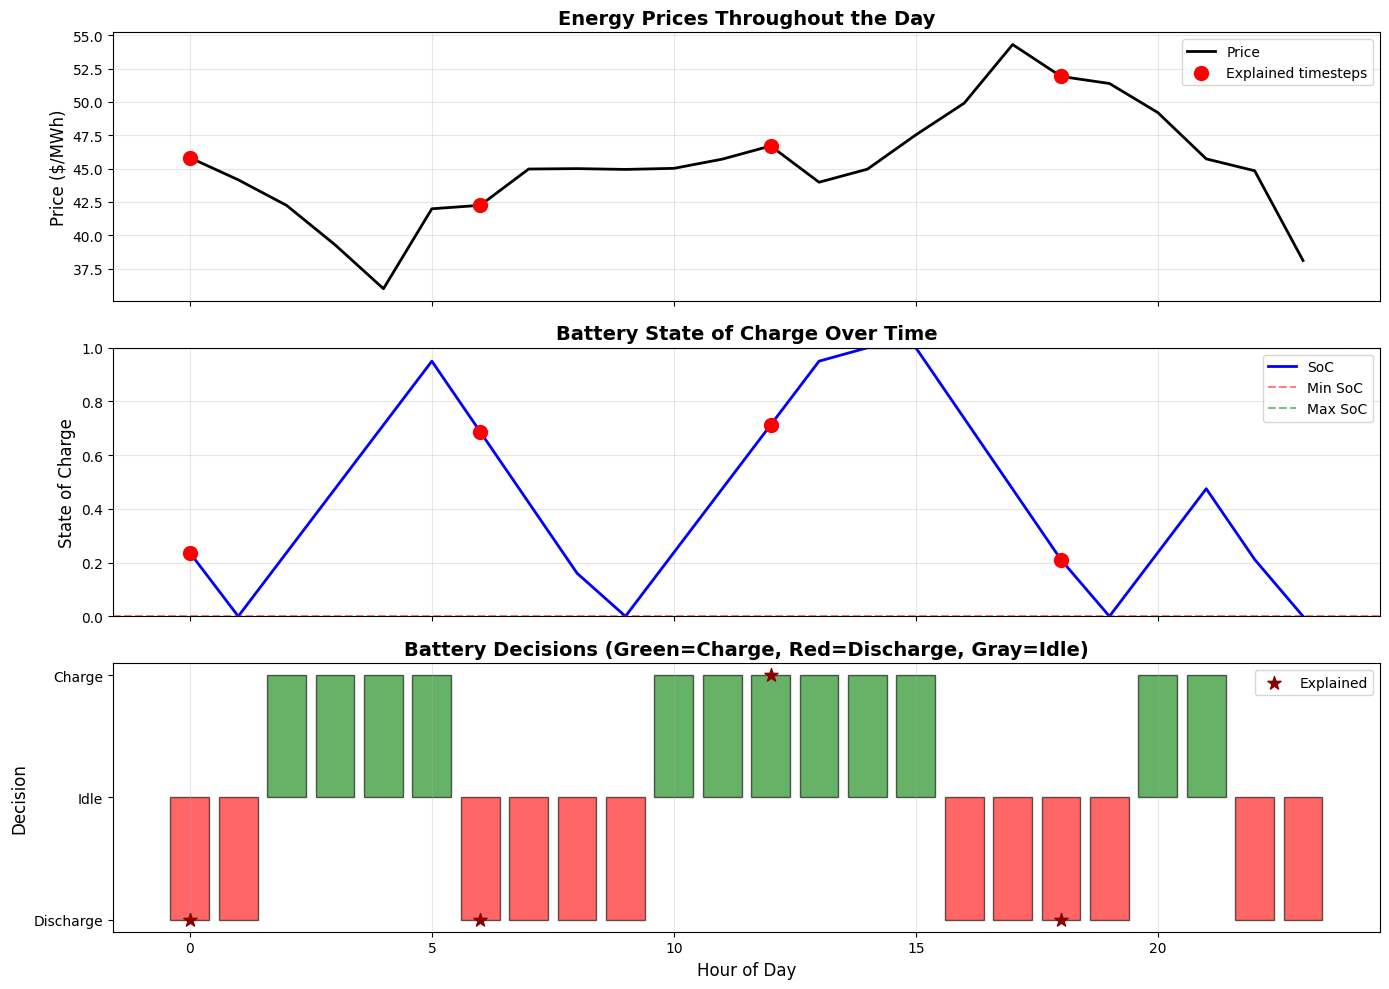


✓ Visualization complete


In [7]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

hours = np.arange(24)

# Plot 1: Prices with explained timesteps marked
axes[0].plot(hours, prices, 'k-', linewidth=2, label='Price')
axes[0].scatter(interesting_hours, [prices[i] for i in interesting_hours], 
                color='red', s=100, zorder=5, label='Explained timesteps')
axes[0].set_ylabel('Price ($/MWh)', fontsize=12)
axes[0].set_title('Energy Prices Throughout the Day', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: State of Charge
axes[1].plot(hours, result_time.soc, 'b-', linewidth=2, label='SoC')
axes[1].scatter(interesting_hours, [result_time.soc[i] for i in interesting_hours],
                color='red', s=100, zorder=5)
axes[1].axhline(y=battery.soc_min, color='r', linestyle='--', alpha=0.5, label='Min SoC')
axes[1].axhline(y=battery.soc_max, color='g', linestyle='--', alpha=0.5, label='Max SoC')
axes[1].set_ylabel('State of Charge', fontsize=12)
axes[1].set_title('Battery State of Charge Over Time', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1])

# Plot 3: Decisions
colors = ['red' if d == -1 else 'green' if d == 1 else 'gray' for d in result_time.decision]
axes[2].bar(hours, result_time.decision, color=colors, alpha=0.6, edgecolor='black')
axes[2].scatter(interesting_hours, [result_time.decision[i] for i in interesting_hours],
                color='darkred', s=100, zorder=5, marker='*', label='Explained')
axes[2].set_ylabel('Decision', fontsize=12)
axes[2].set_xlabel('Hour of Day', fontsize=12)
axes[2].set_title('Battery Decisions (Green=Charge, Red=Discharge, Gray=Idle)', fontsize=14, fontweight='bold')
axes[2].set_yticks([-1, 0, 1])
axes[2].set_yticklabels(['Discharge', 'Idle', 'Charge'])
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete")

## Summary

This notebook demonstrates:

✅ **Reasoning Pipeline Integration**: LLM-based reasoning layer successfully explains battery decisions  
✅ **Heuristic Optimization**: Time-based strategy optimizes battery charging/discharging  
✅ **Natural Language Explanations**: Clear explanations of why decisions were made  
✅ **Confidence Scores**: Each explanation includes a confidence level  
✅ **Key Factors**: Highlights important factors influencing each decision  
✅ **Visualization**: Visual context for understanding decision patterns  

## Next Steps

- Try different heuristic strategies (quantile-based, etc.)
- Compare explanations across different optimization algorithms (MILP, RL, Heuristics)
- Adjust the reasoning instructions for different types of explanations
- Test on different market regions and time periods